# CNN Model with VGG-16

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing the Images

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CNN-CNR/Datasets/final-200-train-test/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CNN-CNR/Datasets/final-200-train-test/test', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)



In [3]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import KFold
import copy
import os
from datetime import datetime
from torch.utils.data import SubsetRandomSampler
import torch
from torch.utils.data import DataLoader

## Load and Modifyng VGG-16 Model

In [4]:
import torch.nn as nn
import torchvision.models as models

def load_vgg16_model():
  vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')

  # Freeze all convolutional layers
  for param in vgg16.features.parameters():
      param.requires_grad = False

  # Modify the classifier
  num_classes = len(train_dataset.classes)
  vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

  # unfreeze some higher layers if needed
  for param in vgg16.features[20:].parameters():
    param.requires_grad = True

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  vgg16 = vgg16.to(device)

  return vgg16, device

vgg16, device = load_vgg16_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s]


## Training

In [5]:
import torch.optim as optim
from sklearn.model_selection import KFold
import copy
import os
from datetime import datetime
from torch.utils.data import SubsetRandomSampler, DataLoader
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_model(model, dataset, device, k_folds=5, epochs=15, batch_size=32, learning_rate=1e-4, step_size=7, gamma=0.1, save_dir='/content/drive/MyDrive/CNN-CNR/Models/'):
    """
    Trains the model using K-Fold Cross-Validation and saves the best model based on validation accuracy.
    Additionally, plots the average training and validation accuracy across all folds.

    Args:
        model (nn.Module): The neural network model to train.
        dataset (Dataset): The dataset to use for training.
        device (torch.device): The device to run the training on.
        k_folds (int): Number of folds for cross-validation.
        epochs (int): Number of training epochs per fold.
        batch_size (int): Batch size for DataLoader.
        learning_rate (float): Initial learning rate.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
        save_dir (str): Directory to save the best model and plot.
    """
    criterion = nn.CrossEntropyLoss()

    # Initialize K-Fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    best_models = []
    best_acc = 0.0

    os.makedirs(save_dir, exist_ok=True)

    current_date = datetime.now().strftime("%m_%d_%Y")  # Format: MM_DD_YYYY

    # Initialize lists to store accuracy per epoch for all folds
    all_train_acc = [[] for _ in range(epochs)]
    all_val_acc = [[] for _ in range(epochs)]

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        train_subsampler = SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)

        # Define data loaders for training and validation
        train_loader_fold = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler, num_workers=2)
        val_loader_fold = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler, num_workers=2)

        # Initialize the model
        model_fold = copy.deepcopy(model)
        model_fold = model_fold.to(device)

        # Define optimizer
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_fold.parameters()), lr=learning_rate)

        # Define the learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        best_acc_fold = 0.0
        best_model_fold = copy.deepcopy(model_fold.state_dict())

        for epoch in range(epochs):
            model_fold.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader_fold:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                # Calculate training accuracy
                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            epoch_loss = running_loss / len(train_subsampler)
            epoch_train_acc = correct_train / total_train

            # Validation phase
            model_fold.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader_fold:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model_fold(inputs)
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            epoch_val_acc = correct / total
            print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}')

            # Append accuracies to the all_folds lists
            all_train_acc[epoch].append(epoch_train_acc)
            all_val_acc[epoch].append(epoch_val_acc)

            if epoch_val_acc > best_acc_fold:
                best_acc_fold = epoch_val_acc
                best_model_fold = copy.deepcopy(model_fold.state_dict())

            # Step the scheduler
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            print(f'Current Learning Rate: {current_lr}')

        print(f'Best Validation Accuracy for Fold {fold+1}: {best_acc_fold:.4f}')
        best_models.append((best_model_fold, best_acc_fold))
        print('--------------------------------')

    # Select the model with the highest accuracy across all folds
    best_models.sort(key=lambda x: x[1], reverse=True)
    best_model_state_dict, best_model_accuracy = best_models[0]

    # Define the filename with the current date and time
    current_datetime = datetime.now().strftime("%m_%d_%Y_%H_%M")
    model_filename = f'vgg16_model_{current_datetime}_{best_model_accuracy}.pth'

    save_path = os.path.join(save_dir, model_filename)

    # Save the best model
    torch.save(best_model_state_dict, save_path)
    print(f'Best Model saved with Accuracy: {best_model_accuracy:.4f} to {save_path}')

    # Calculate average accuracy across all folds for each epoch
    avg_train_acc = [sum(acc_list) / len(acc_list) for acc_list in all_train_acc]
    avg_val_acc = [sum(acc_list) / len(acc_list) for acc_list in all_val_acc]

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))
    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, avg_train_acc, label='Average Training Accuracy')
    plt.plot(epochs_range, avg_val_acc, label='Average Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Across Epochs')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = f'accuracy_plot_{current_datetime}.png'
    plot_path = os.path.join(save_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f'Accuracy plot saved to {plot_path}')

    #ADD for see the confusion matrix
    # Load the best model
    best_model = copy.deepcopy(model)
    best_model.load_state_dict(best_model_state_dict)
    best_model = best_model.to(device)
    best_model.eval()

    # Prepare data loaders for the entire dataset (validation phase only)
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Accumulate predictions and true labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for the Best Model')
    plt.savefig(os.path.join(save_dir, f'confusion_matrix_{current_datetime}.png'))
    plt.show()
    print(f"Confusion matrix saved to {save_dir}")


FOLD 1
--------------------------------
Epoch 1/15 | Loss: 1.2364 | Train Acc: 0.6147 | Val Acc: 0.8550
Current Learning Rate: 0.0001
Epoch 2/15 | Loss: 0.3270 | Train Acc: 0.8928 | Val Acc: 0.9163
Current Learning Rate: 0.0001
Epoch 3/15 | Loss: 0.1578 | Train Acc: 0.9456 | Val Acc: 0.9263
Current Learning Rate: 0.0001
Epoch 4/15 | Loss: 0.0973 | Train Acc: 0.9712 | Val Acc: 0.9038
Current Learning Rate: 0.0001
Epoch 5/15 | Loss: 0.0751 | Train Acc: 0.9791 | Val Acc: 0.9275
Current Learning Rate: 0.0001
Epoch 6/15 | Loss: 0.0429 | Train Acc: 0.9847 | Val Acc: 0.9100
Current Learning Rate: 0.0001
Epoch 7/15 | Loss: 0.0299 | Train Acc: 0.9912 | Val Acc: 0.9363
Current Learning Rate: 1e-05
Epoch 8/15 | Loss: 0.0066 | Train Acc: 0.9984 | Val Acc: 0.9450
Current Learning Rate: 1e-05
Epoch 9/15 | Loss: 0.0024 | Train Acc: 1.0000 | Val Acc: 0.9463
Current Learning Rate: 1e-05
Epoch 10/15 | Loss: 0.0019 | Train Acc: 1.0000 | Val Acc: 0.9450
Current Learning Rate: 1e-05
Epoch 11/15 | Loss: 0.0

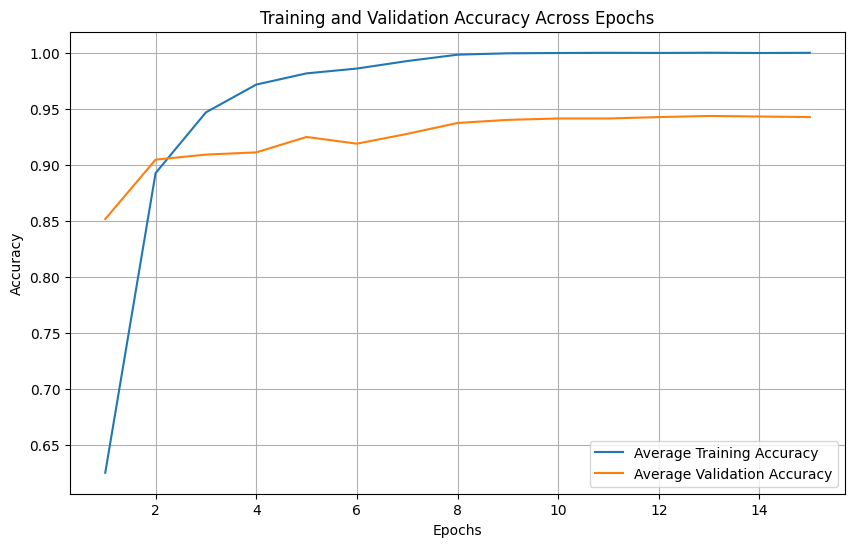

Accuracy plot saved to /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-200/accuracy_plot_01_25_2025_15_44.png


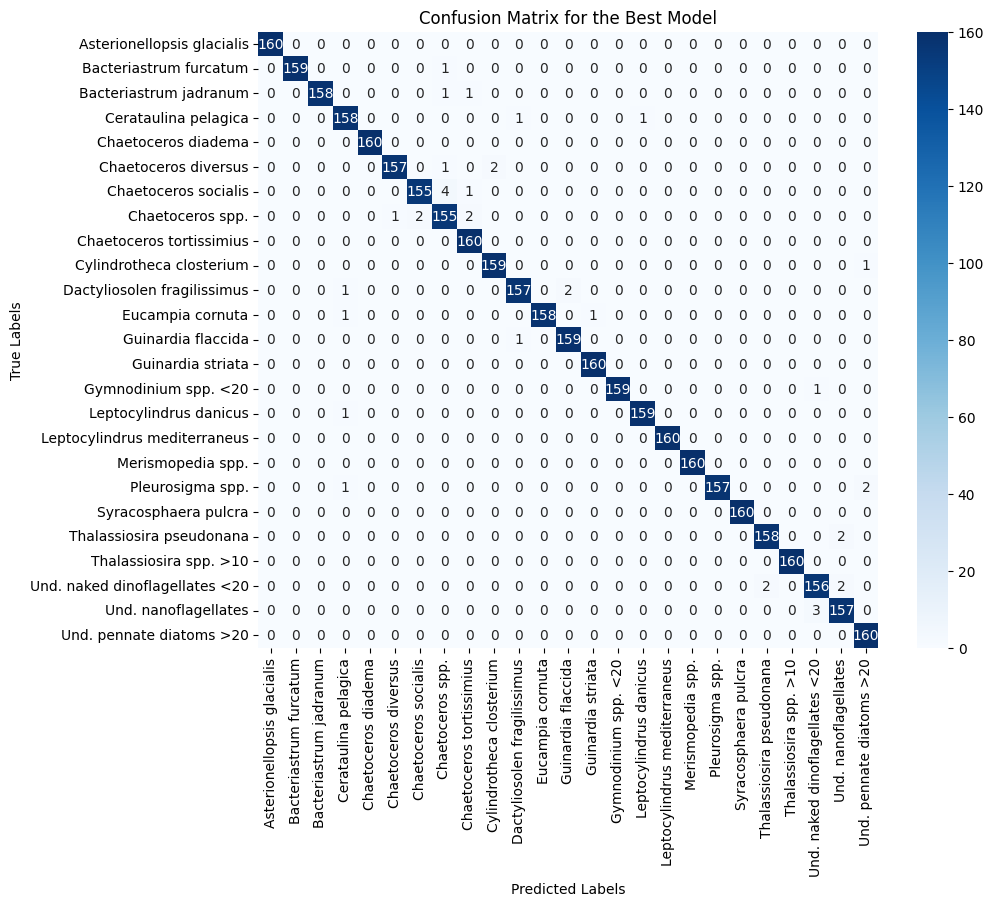

Confusion matrix saved to /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-200


In [6]:
# Parameters
k_folds = 5
epochs = 15
batch_size = 64
learning_rate = 1e-4
step_size = 7
gamma = 0.1
save_dir = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-200'



train_model(
    model=vgg16,
    dataset=train_dataset,
    device = device,
    k_folds=k_folds,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    step_size=step_size,
    gamma=gamma,
    save_dir=save_dir
  )

## Testing

In [7]:
import os
import glob
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import plotly.express as px
from torchvision.models import VGG16_Weights


In [8]:
def plot_per_class_accuracy_continuous(per_class_accuracy, class_names, color_scale='RdYlBu'):
    """
    Creates an interactive bar chart for per-class accuracy with a continuous color scale.

    Args:
        per_class_accuracy (list or array): Accuracy for each class.
        class_names (list): Names of the classes.
        color_scale (str or list, optional): Plotly color scale to use. Default is 'RdYlBu'.
    """
    # Create a DataFrame
    df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': per_class_accuracy
    })

    fig = px.bar(
        df,
        x='Class',
        y='Accuracy',
        color='Accuracy',
        color_continuous_scale=color_scale,
        hover_data={'Class': True, 'Accuracy': ':.2f'},
        labels={'Accuracy': 'Accuracy'},
        title='Per-Class Accuracy',
        range_y=[0, 1]
    )

    fig.update_layout(
        xaxis_title='Classes',
        yaxis_title='Accuracy',
        coloraxis_colorbar=dict(
            title="Accuracy",
            tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
            ticktext=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]
        )
    )

    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>Accuracy: %{y:.2f}<extra></extra>'
    )

    fig.show()


def group_classes_by_recall(per_class_recall, class_names, bins=None, plot=True):
    """
    Groups the number of classes based on their recall into specified ranges.

    Args:
        per_class_recall (list or array): Recall values for each class.
        class_names (list): List of class names corresponding to the recall values.
        bins (list of tuples, optional): List of (min, max) tuples defining recall ranges.
                                         Defaults to predefined ranges:
                                         [(0.9, 1.0), (0.8, 0.89), (0.7, 0.79), (0.6, 0.69), (0.0, 0.59)]
        plot (bool, optional): Whether to plot the group counts. Defaults to True.

    Returns:
        dict: A dictionary with bin labels as keys and counts as values.
    """
    if bins is None:
        bins = [
            (0.9, 1.0),
            (0.8, 0.899),
            (0.7, 0.799),
            (0.6, 0.699),
            (0.5, 0.599),
            (0.4, 0.499),
            (0.3, 0.399),
            (0.2, 0.299),
            (0.1, 0.199),
            (0.0, 0.1)
        ]

    # Define bin labels
    bin_labels = [
        '0.9 - 1.0',
        '0.8 - 0.899',
        '0.7 - 0.799',
        '0.6 - 0.699',
        '0.5 - 0.599',
        '0.4 - 0.499',
        '0.3 - 0.399',
        '0.2 - 0.299',
        '0.1 - 0.199',
        '< 0.1'
    ]

    # Initialize counts
    bin_counts = {label: 0 for label in bin_labels}
    bin_class_names = {label: [] for label in bin_labels}

    # Assign each class to a bin
    for recall, class_name in zip(per_class_recall, class_names):
        placed = False
        for (min_val, max_val), label in zip(bins, bin_labels):
            if min_val <= recall <= max_val:
                bin_counts[label] += 1
                bin_class_names[label].append(class_name)
                placed = True
                break
        if not placed:
            print(f"Recall value {recall} for class '{class_name}' does not fit into any bin.")

    # Print the counts
    print("\nNumber of classes in each recall range:")
    for label in bin_labels:
        print(f"{label}: {bin_counts[label]}")

    return bin_counts, bin_class_names

Plots functions

In [9]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(conf_matrix, class_names, save_path=None):

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved at: {save_path}")

    plt.show()

    plt.close()


def plot_true_false_positive(conf_matrix, class_names, save_path=None):

    total_set = conf_matrix.sum(axis=1)  # Total images per class
    true_positive = conf_matrix.diagonal()  # True positives
    false_positive = conf_matrix.sum(axis=0) - conf_matrix.diagonal()  # False positives

    plt.figure(figsize=(16, 8))
    x = np.arange(len(class_names))  # Indices for classes
    width = 0.3  # Width of each bar

    plt.bar(x - width, total_set, width=width, label='Total Set', color='blue')
    plt.bar(x, true_positive, width=width, label='True Positives (TP)', color='green')
    plt.bar(x + width, false_positive, width=width, label='False Positives (FP)', color='red')

    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylabel('Count')
    plt.xlabel('Classes')
    plt.title('True Positives and False Positives per Class')
    plt.legend(loc='upper right')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"True/False Positives chart saved at: {save_path}")

    plt.show()

    plt.close()


def plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=0.8, save_path=None):

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, per_class_recall, color='c')
    plt.axhline(y=accuracy_threshold, color='r', linestyle='--', label='Threshold')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Classes')
    plt.ylabel('Recall')
    plt.title('Recall per Class')
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Per-class recall chart saved at: {save_path}")


    plt.show()

    plt.close()



def write_results_to_txt(save_path: str,model_name: str, model_path: str, device: torch.device, overall_accuracy: float, precision: float, recall: float, f1: float, class_report: str,
    per_class_accuracy: list, class_names: list, zero_pred_classes: list, memory_used: float, execution_time: float, resources):

    txt_path = os.path.join(save_path, f"{model_name}.txt")
    with open(txt_path, 'w') as f:
        f.write(f"Model Evaluation Results\n")
        f.write(f"Model Path: {model_path}\n")
        f.write(f"Device: {device}\n\n")

        f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n")
        f.write(f"Weighted Precision: {precision:.4f}\n")
        f.write(f"Weighted Recall: {recall:.4f}\n")
        f.write(f"Weighted F1-Score: {f1:.4f}\n\n")

        f.write("Classification Report:\n")
        f.write(class_report + "\n")

        f.write("Per-Class Accuracy:\n")
        for idx, class_name in enumerate(class_names):
            f.write(f" - {class_name}: {per_class_accuracy[idx]:.4f}\n")

        if zero_pred_classes:
            f.write("\nClasses with no predictions:\n")
            for class_name in zero_pred_classes:
                f.write(f" - {class_name}\n")
        else:
            f.write("\nAll classes have at least one prediction.\n")

        f.write(f"\nGPU memory used during the test: {memory_used:.2f} MB\n")
        f.write(f"Execution time: {execution_time:.2f} seconds\n")
        f.write(f"Resource used(execution_time / memory_used): {resources:.2f}\n")

    print(f"\nResults saved in: {txt_path}")

### Testing Function

In [10]:
def load_architecture_vgg16(model_path,dataset):

  class_names = test_dataset.classes

  # Define model architecture (VGG16)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_architecture = models.vgg16(weights='VGG16_Weights.DEFAULT')
  num_classes = len(class_names)
  model_architecture.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
  model_architecture.to(device)

  if model_path:
      model_architecture.load_state_dict(torch.load(model_path, map_location=device))

  return model_architecture, class_names, device

In [11]:
import os
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

from tqdm import tqdm
import seaborn as sns
import time
import psutil


def test_model(
    model_path: str,
    model_architecture: torch.nn.Module = None,
    test_loader: torch.utils.data.DataLoader = None,
    device: torch.device = None,
    class_names: list = None,
    accuracy_threshold: float = 0.8,
    save_path: str = None
) -> dict:

    if model_architecture is None:
        raise ValueError("model_architecture must be provided.")

    if test_loader is None:
        raise ValueError("test_loader must be provided.")

    if class_names is None:
        raise ValueError("class_names must be provided.")

    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"The specified model_path does not exist or is not a file: {model_path}")

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cuda":
        before_memory = torch.cuda.memory_allocated(device)
    else:
        process = psutil.Process(os.getpid())
        before_memory = process.memory_info().rss

    # Misurazione tempo di inizio
    start_time = time.time()

    '''
    print(f'Loading model from: {model_path}')

    try:
        model_architecture.load_state_dict(torch.load(model_path, map_location=device))
    except RuntimeError as e:
        print(f"RuntimeError while loading model weights: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error while loading model: {e}")
        return None
    '''
    model_architecture.to(device)
    model_architecture.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_architecture(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Misurazione tempo di fine
    end_time = time.time()

    # Misurazione memoria dopo il test
    if device.type == "cuda":
        after_memory = torch.cuda.memory_allocated(device)
        peak_memory = torch.cuda.max_memory_allocated(device)
        memory_used = (peak_memory - before_memory) / (1024 ** 2)  # In MB
    else:
        process = psutil.Process(os.getpid())
        after_memory = process.memory_info().rss
        memory_used = (after_memory - before_memory) / (1024 ** 2)  # In MB

    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f'\nOverall Accuracy: {overall_accuracy:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    print(f'Weighted Precision: {precision:.4f}')
    print(f'Weighted Recall: {recall:.4f}')
    print(f'Weighted F1-Score: {f1:.4f}')

    conf_matrix = confusion_matrix(all_labels, all_preds)

    class_report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print('\nClassification Report:')
    print(class_report)

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
    per_class_recall = [report_dict[class_name]['recall'] for class_name in class_names]

    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        per_class_accuracy = np.nan_to_num(per_class_accuracy)

    print('Per-Class Accuracy:')
    for idx, class_name in enumerate(class_names):
        print(f' - {class_name}: {per_class_accuracy[idx]:.4f}')

    predictions_per_class = conf_matrix.sum(axis=0)
    zero_pred_classes = [class_names[i] for i, count in enumerate(predictions_per_class) if count == 0]

    if zero_pred_classes:
        print(f"\nClasses with no predictions: {zero_pred_classes}")
    else:
        print("\nAll classes have at least one prediction.")

    execution_time = end_time - start_time
    resources = execution_time * memory_used if memory_used > 0 else float('inf')  # Opzionale

    if save_path is not None:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        model_name = os.path.splitext(os.path.basename(model_path))[0]
        conf_matrix_path = os.path.join(save_path, f"{model_name}_conf_matrix.png")
        bar_plot_path = os.path.join(save_path, f"{model_name}_true_false_positive.png")
        recall_plot_path = os.path.join(save_path, f"{model_name}_recall_plot.png")


        write_results_to_txt(save_path=save_path, model_name=model_name, model_path=model_path, device=device, overall_accuracy=overall_accuracy,
            precision=precision, recall=recall, f1=f1, class_report=class_report, per_class_accuracy=per_class_accuracy, class_names=class_names,
            zero_pred_classes=zero_pred_classes, memory_used=memory_used, execution_time=execution_time, resources=resources )


        plot_confusion_matrix(conf_matrix, class_names, save_path=conf_matrix_path)
        plot_true_false_positive(conf_matrix, class_names, save_path=bar_plot_path)
        plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=accuracy_threshold, save_path=recall_plot_path)

    results = {
        'overall_accuracy': overall_accuracy,
        'weighted_precision': precision,
        'weighted_recall': recall,
        'weighted_f1': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'per_class_recall': per_class_recall,
        'per_class_accuracy': per_class_accuracy,
        'zero_pred_classes': zero_pred_classes
    }

    print(f"\nGPU memory used during the test: {memory_used:.2f} MB")  # GPU memory used during the test in MB
    print(f"Execution time: {execution_time:.2f} seconds")  # Total execution time in seconds
    print(f"Resource used(execution_time / memory_used): {resources:.2f}")

    return results



### Main

In [12]:
model_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model/vgg16-200/vgg16_model_01_25_2025_15_44_0.95125.pth'

save_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16'   # to save results in txt file

model_architecture,class_names, device = load_architecture_vgg16(model_path,test_dataset)

<ipython-input-10-e9a286fdefc6>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(model_path, map_location=device))


Evaluating: 100%|██████████| 16/16 [06:18<00:00, 23.65s/it]



Overall Accuracy: 0.9160
Weighted Precision: 0.9178
Weighted Recall: 0.9160
Weighted F1-Score: 0.9141

Classification Report:
                                precision    recall  f1-score   support

    Asterionellopsis glacialis       0.95      0.97      0.96        40
        Bacteriastrum furcatum       0.94      0.85      0.89        40
        Bacteriastrum jadranum       0.95      1.00      0.98        40
          Cerataulina pelagica       0.82      1.00      0.90        40
           Chaetoceros diadema       0.84      0.90      0.87        40
          Chaetoceros diversus       0.91      0.97      0.94        40
          Chaetoceros socialis       0.86      0.93      0.89        40
              Chaetoceros spp.       0.79      0.57      0.67        40
      Chaetoceros tortissimius       0.88      0.93      0.90        40
      Cylindrotheca closterium       0.87      1.00      0.93        40
   Dactyliosolen fragilissimus       0.95      1.00      0.98        40
        

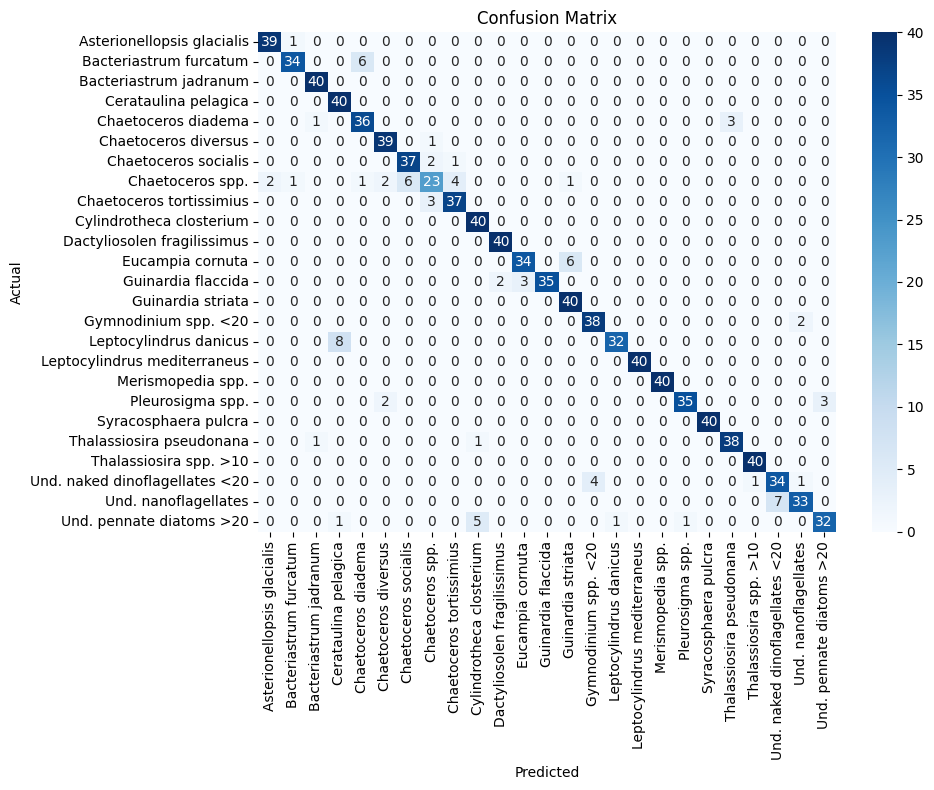

True/False Positives chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-200/vgg16_model_01_25_2025_15_44_0.95125_true_false_positive.png


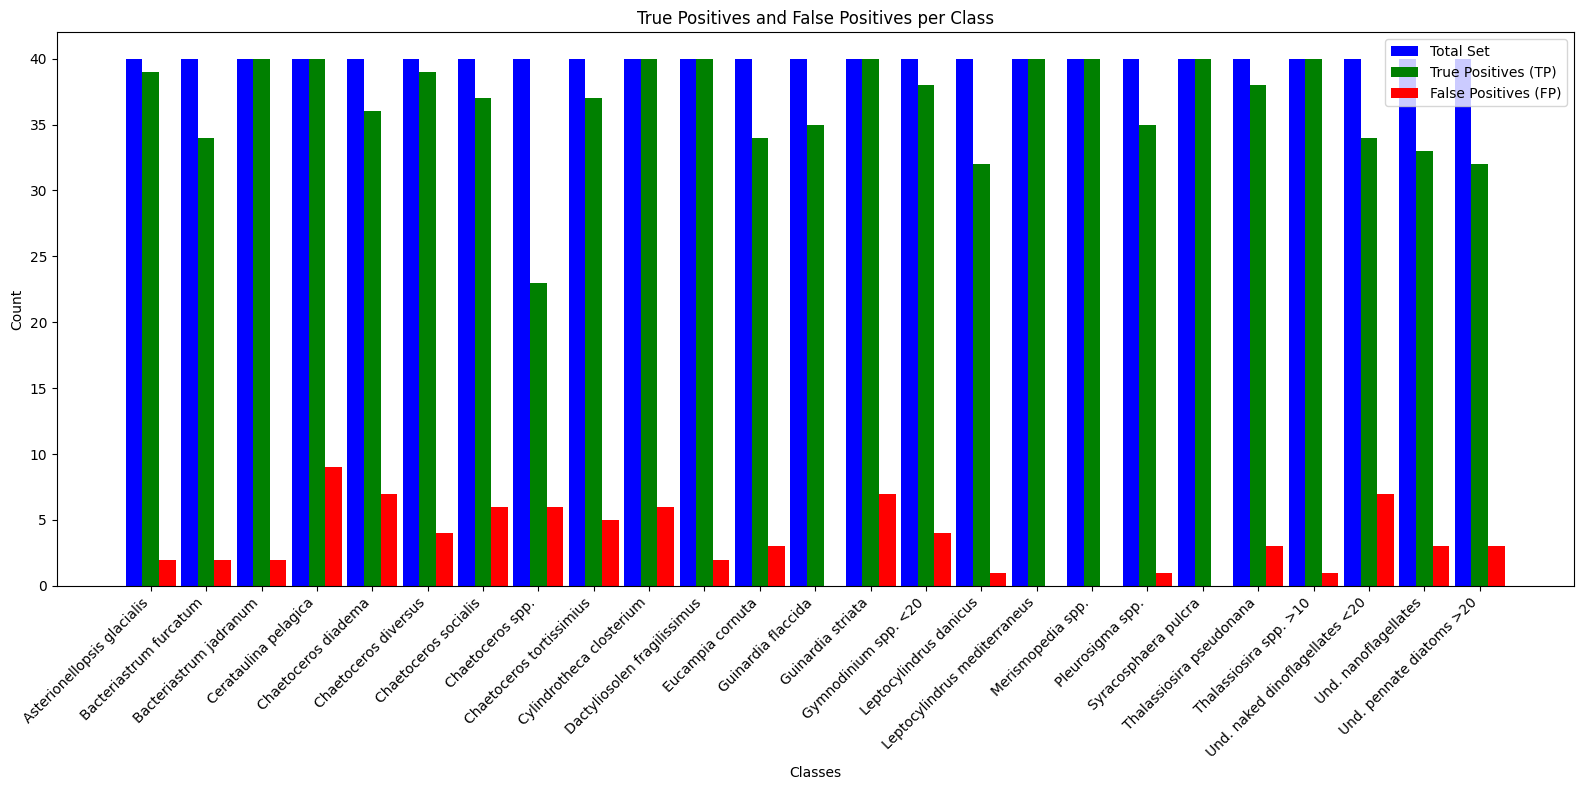

Per-class recall chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-200/vgg16_model_01_25_2025_15_44_0.95125_recall_plot.png


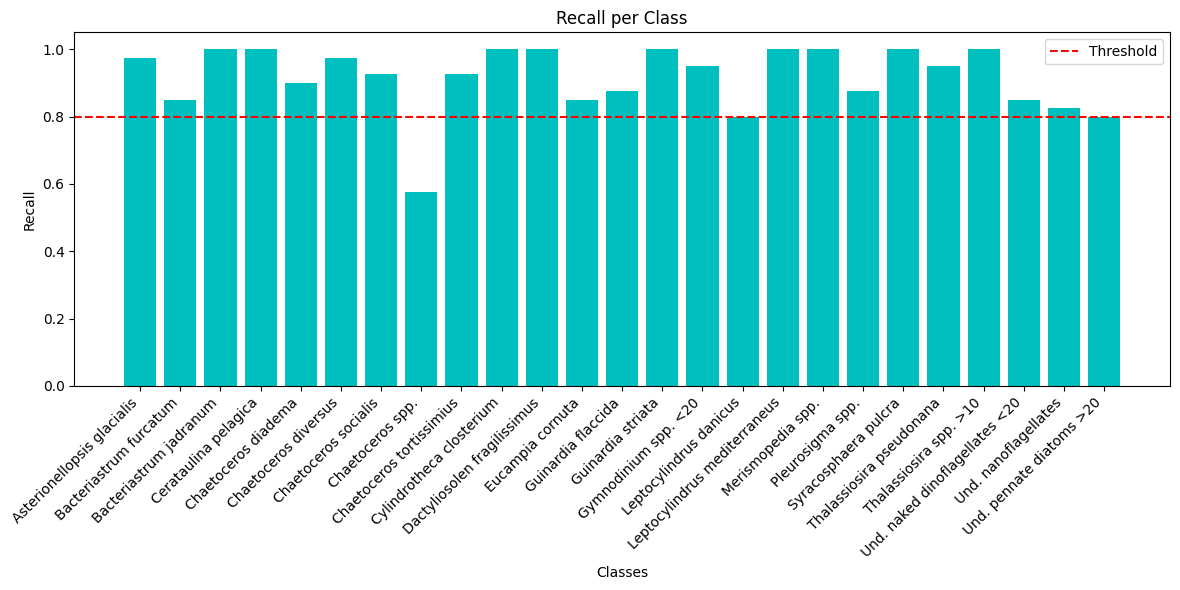


GPU memory used during the test: 9691.94 MB
Execution time: 378.34 seconds
Resource used(execution_time / memory_used): 3666868.12


In [13]:
# Evaluate the model
results = test_model(
    model_path=model_path,
    model_architecture=model_architecture,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    accuracy_threshold=0.8,
    save_path=save_path
)